In [1]:
import os
import json

import numpy as np
import pandas as pd
import random
from collections import Counter
import math
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from collections import Counter

import sklearn.cluster

import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec

from tqdm import tqdm

from scipy import stats
from scipy.spatial import distance
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit

import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation

In [2]:
def entropy(data):
    counts = Counter(data)
    total = len(data)

    entropy_value = -sum((count / total) * math.log2(count / total) for count in counts.values())

    return entropy_value

In [3]:
def func(x, a, b):
    return a * x + b


def log_func(x, a, w, b):
    return np.log(a * (x + b)) * w


def plot_with_interval(X, y, func=func):
    popt, pcov = curve_fit(func, X, y)
    fit_line = func(X, *popt)
    sigma = np.sqrt(np.diag(pcov)[0] * X ** 2 + np.diag(pcov)[1])
    upper_bound = fit_line + sigma
    lower_bound = fit_line - sigma

    plt.scatter(X, y, label='Data')
    plt.plot(X, fit_line, 'r--', label='Fit')
    plt.fill_between(X, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')

    plt.legend()
    plt.show()


def plot_log_with_interval(X, y, func=log_func):
    popt, pcov = curve_fit(log_func, X, y)
    fit_line = func(X, *popt)
    sigma = np.sqrt(np.diag(pcov)[0] * X ** 2 + np.diag(pcov)[1])
    upper_bound = fit_line + sigma
    lower_bound = fit_line - sigma

    plt.scatter(X, y, label='Data')
    plt.plot(X, fit_line, 'r--', label='Fit')
    plt.fill_between(X, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')

    plt.legend()
    plt.show()

In [4]:
def get_OLS_param(X, y):
    X_con = sm.add_constant(X)
    lm2 = sm.OLS(y, X_con).fit()

    return lm2.rsquared_adj, lm2.params.iloc[0], lm2.params.iloc[1], lm2.bse.iloc[1]

In [5]:
def mediation_scf(df_op):
    y = df_op['context']
    X_cols = ['structure']
    X = sm.add_constant(df_op[X_cols])
    mediator_model = sm.OLS(y, X)

    # For the second step of the mediation model, we can add in other predictors.
    y = df_op['function']
    X_cols = ['structure', 'context']
    X = sm.add_constant(df_op[X_cols])
    outcome_model = sm.OLS(y, X)

    med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                    exposure='structure', mediator='context').fit()
    print("General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)\n")

    return med


def log_mediation_scf(df_op):
    y = df_op['context']
    X_cols = ['structure']
    X = sm.add_constant(df_op[X_cols])
    mediator_model = sm.OLS(y, X)

    # For the second step of the mediation model, we can add in other predictors.
    y = df_op['function'].apply(np.exp)
    X_cols = ['structure', 'context']
    X = sm.add_constant(df_op[X_cols])
    outcome_model = sm.OLS(y, X)

    med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                    exposure='structure', mediator='context').fit()
    print("General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)\n")

    return med

In [14]:
df_wi = pd.read_csv('./pWithin_cor_2.csv')
df_wi

,pmid,A,B,structure,function,year
0,7562510,"1,2-bis(2-aminophenoxy)ethane N,N,N',N'-tetraa...","1,2-Dimethylhydrazine",0.921208,1.325248,1995
1,7562510,"1,2-bis(2-aminophenoxy)ethane N,N,N',N'-tetraa...","1,3-dimethylthiourea",0.902102,1.320811,1995
2,7562510,"1,2-bis(2-aminophenoxy)ethane N,N,N',N'-tetraa...","1-(4-(6-bromobenzo(1,3)dioxol-5-yl)-3a,4,5,9b-...",0.385399,1.104017,1995
3,7562510,"1,2-bis(2-aminophenoxy)ethane N,N,N',N'-tetraa...","1-(6-((3-methoxyestra-1,3,5(10)-trien-17-yl)am...",0.638794,0.728872,1995
4,7562510,"1,2-bis(2-aminophenoxy)ethane N,N,N',N'-tetraa...",1-Butanol,0.897048,1.034472,1995
...,...,...,...,...,...,...
2629098,10658937,vinclozolin,W 7,0.377573,0.915605,2000
2629099,10658937,vinclozolin,Water,0.898443,0.847266,2000
2629100,10658937,Vitamin A,W 7,0.935338,0.922619,2000
2629101,10658937,Vitamin A,Water,1.028463,1.255033,2000


In [15]:
s_mean, s_std = df_wi['structure'].mean(), df_wi['structure'].std()
f_mean, f_std = df_wi['function'].mean(), df_wi['function'].std()

In [16]:
pearsonr(df_wi['structure'], df_wi['function'])

PearsonRResult(statistic=7.40565257895093e-05, pvalue=0.904420596904842)

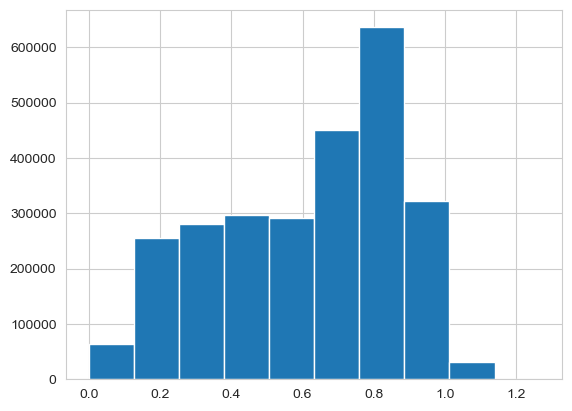

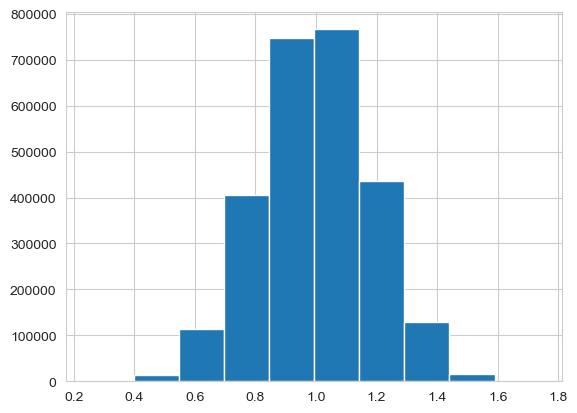

In [17]:
df_wi['structure'].hist()
plt.show()
df_wi['function'].hist()
plt.show()

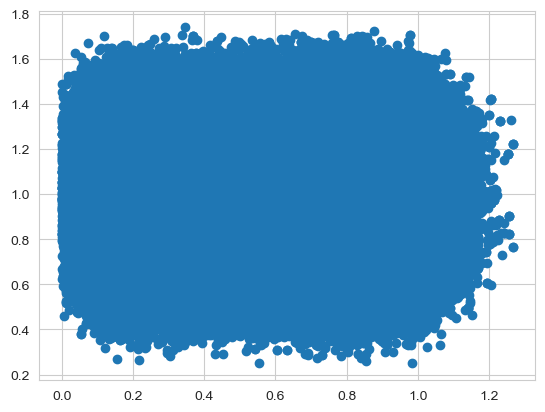

In [18]:
plt.scatter(df_wi['structure'], df_wi['function'])

In [109]:
df_wi['structure'].max(), df_wi['function'].max()

(1.2657395183746103, 1.7388553136467446)

In [19]:
df_wi['structure'].mean(), df_wi['function'].mean()

(0.614823490210669, 1.0000127538616153)

In [7]:
df_c = pd.read_csv('./df_c.csv')
df_pw_o = pd.read_csv('./pw_cor.csv')
df_pw_o

,A,B,structure,function,context,cluster
0,7582491,9496914,0.023060,0.657213,0.581446,False
1,9754764,10591678,0.012996,0.631354,0.676547,False
2,6350720,3287162,0.004840,0.542359,0.701220,False
3,8712863,1407345,0.010255,0.791801,0.751410,False
4,8215636,10195895,0.011716,0.511900,0.650449,False
...,...,...,...,...,...,...
3995,2545777,9571255,0.014635,0.706679,0.612833,False
3996,9147382,2992854,0.014456,0.845441,0.746666,False
3997,7979221,9598899,0.000114,0.077057,0.585082,False
3998,3459889,7582491,0.009179,0.611576,0.618023,False


0.0017249241643082303 0.09658307015048703


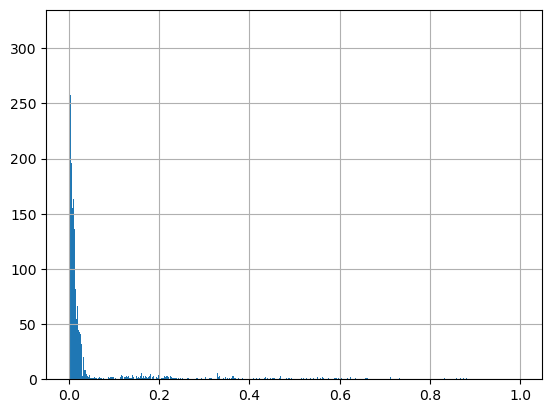

In [438]:
print(df_pw_o['structure'].quantile(0.1), df_pw_o['structure'].quantile(0.9))
df_pw_o.structure.hist(bins=np.arange(0, 1, 0.001))
plt.show()

0.3536419176100595 0.9418402696277628


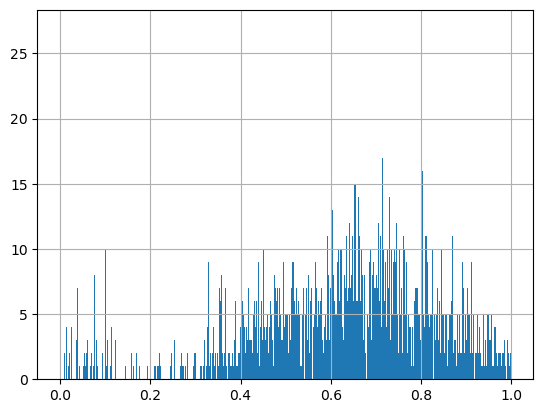

In [439]:
print(df_pw_o['function'].quantile(0.1), df_pw_o['function'].quantile(0.9))
df_pw_o.function.hist(bins=np.arange(0, 1, 0.001))
plt.show()

In [440]:
print(log_mediation_scf(df_pw_o).summary())

General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.115655        0.077836        0.153516      0.0
ACME (treated)            0.115655        0.077836        0.153516      0.0
ADE (control)             1.854095        1.733762        1.971128      0.0
ADE (treated)             1.854095        1.733762        1.971128      0.0
Total effect              1.969749        1.836641        2.088788      0.0
Prop. mediated (control)  0.058849        0.040576        0.077571      0.0
Prop. mediated (treated)  0.058849        0.040576        0.077571      0.0
ACME (average)            0.115655        0.077836        0.153516      0.0
ADE (average)             1.854095        1.733762        1.971128      0.0
Prop. mediated (average)  0.058849        0.040576        0.077571      0.0


In [441]:
print(log_mediation_scf(df_lc).summary())

General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.109548       -0.109903        0.460389    0.412
ACME (treated)            0.109548       -0.109903        0.460389    0.412
ADE (control)             5.384317        3.714493        6.953190    0.000
ADE (treated)             5.384317        3.714493        6.953190    0.000
Total effect              5.493865        3.805269        7.095223    0.000
Prop. mediated (control)  0.015138       -0.020919        0.083246    0.412
Prop. mediated (treated)  0.015138       -0.020919        0.083246    0.412
ACME (average)            0.109548       -0.109903        0.460389    0.412
ADE (average)             5.384317        3.714493        6.953190    0.000
Prop. mediated (average)  0.015138       -0.020919        0.083246    0.412


In [442]:
print(log_mediation_scf(df_gb).summary())

General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.016524        0.003292        0.034362     0.01
ACME (treated)            0.016524        0.003292        0.034362     0.01
ADE (control)             1.744699        1.589407        1.891036     0.00
ADE (treated)             1.744699        1.589407        1.891036     0.00
Total effect              1.761223        1.605739        1.909868     0.00
Prop. mediated (control)  0.008809        0.001899        0.019076     0.01
Prop. mediated (treated)  0.008809        0.001899        0.019076     0.01
ACME (average)            0.016524        0.003292        0.034362     0.01
ADE (average)             1.744699        1.589407        1.891036     0.00
Prop. mediated (average)  0.008809        0.001899        0.019076     0.01


In [444]:
print(log_mediation_scf(df_pw_o[df_pw_o['structure'] < 0.05]).summary())

General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)

                           Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)             1.637326        1.283161        2.021356      0.0
ACME (treated)             1.637326        1.283161        2.021356      0.0
ADE (control)             23.722364       22.357578       24.988337      0.0
ADE (treated)             23.722364       22.357578       24.988337      0.0
Total effect              25.359690       24.042039       26.623120      0.0
Prop. mediated (control)   0.064588        0.050535        0.079745      0.0
Prop. mediated (treated)   0.064588        0.050535        0.079745      0.0
ACME (average)             1.637326        1.283161        2.021356      0.0
ADE (average)             23.722364       22.357578       24.988337      0.0
Prop. mediated (average)   0.064588        0.050535        0.079745      0.0


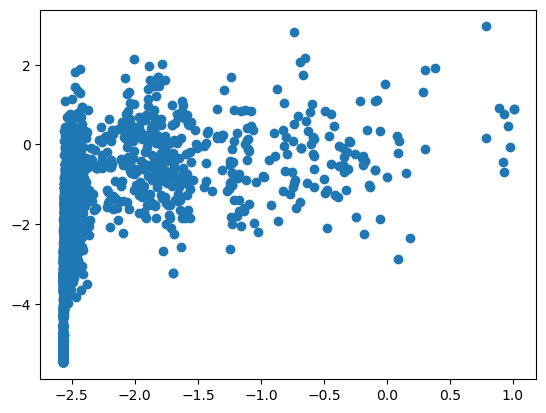

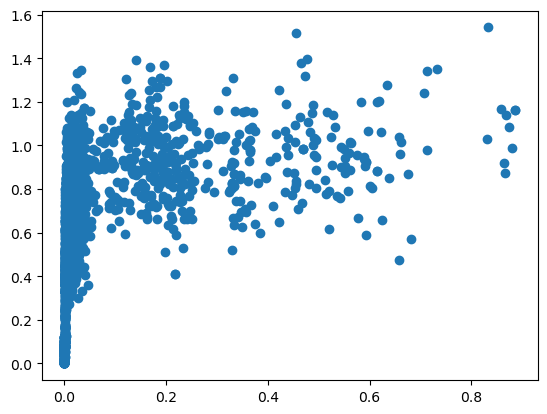

In [487]:
plt.scatter((df_pw_o['structure'] - s_mean) / s_std, (df_pw_o['function'] - f_mean) / f_std)
plt.show()
plt.scatter(df_pw_o['structure'], df_pw_o['function'])

In [9]:
cl = df_pw_o['context'].quantile(0.05)
fr = df_pw_o['context'].quantile(0.50)

df_lc = df_pw_o[df_pw_o['context'] <= cl]
df_gb = df_pw_o[df_pw_o['context'] >= fr]

print(cl, fr)
print(len(df_lc), len(df_gb))
print(df_lc.function.mean(), df_gb.function.mean())

0.45978662882902094 0.6170389011505701
200 2000
0.43939184128439424 0.7016527414420611


In [503]:
df_wi['structure'].mean(), df_wi['function'].mean()

(0.6373779113038041, 0.9998201057379891)

In [502]:
df_pw_o['structure'].mean(), df_wi['structure'].mean()

(0.0404750988070775, 0.6373779113038041)

In [501]:
df_pw_o['structure'].mean(), df_pw_o['function'].mean()

(0.0404750988070775, 0.6445556985180217)

/Users/lyu/anaconda3/envs/transKnow/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


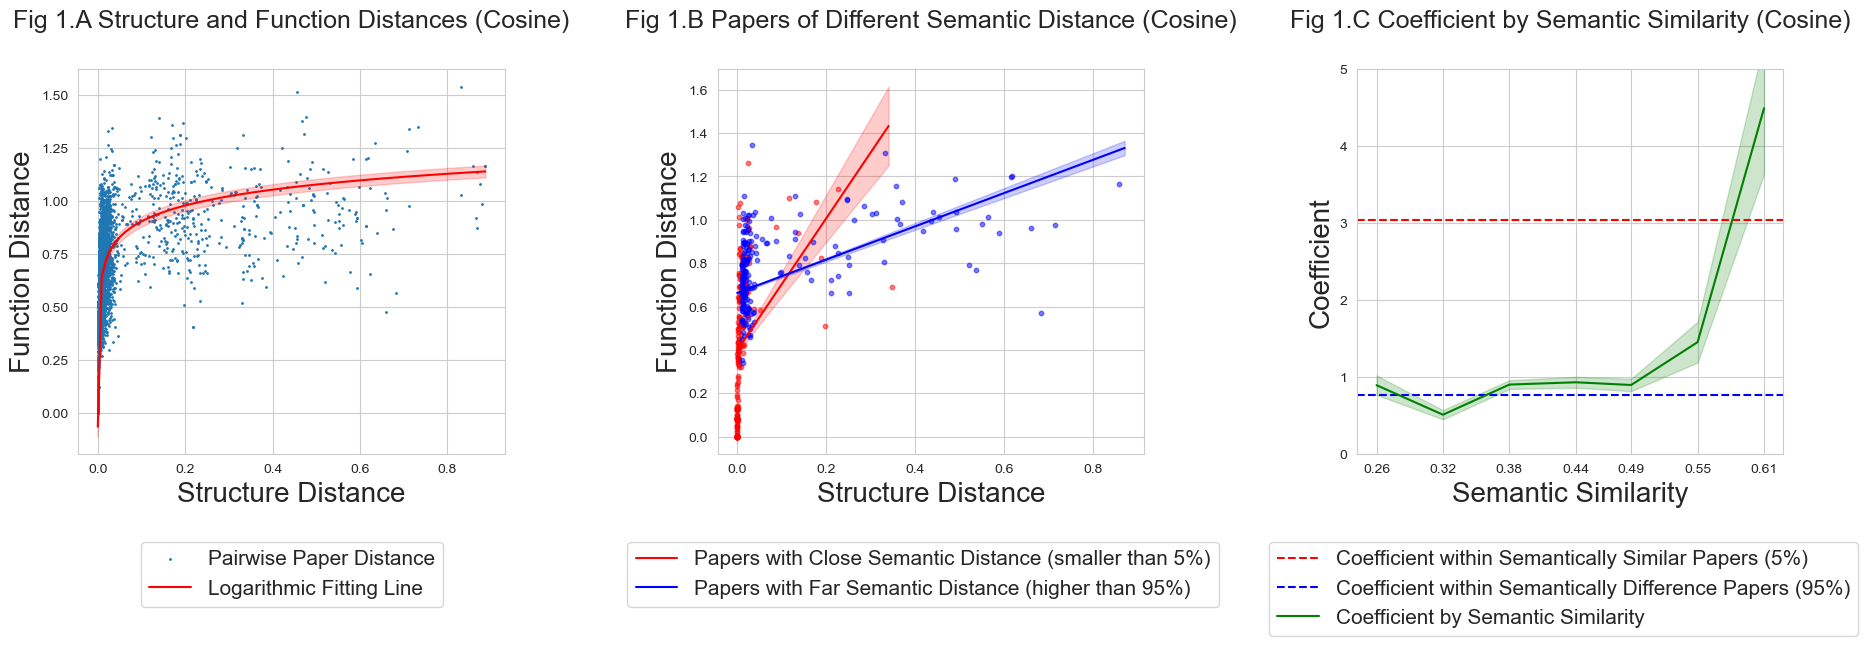

In [108]:
r_squared = []
const = []
para_0 = []
std_err = []
thre = np.linspace(0.1, 1.2, num=20)
t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_o[(df_pw_o['context'] >= thre[i]) & (df_pw_o['context'] < thre[i + 1])]
    y = df_op['function']
    X = df_op['structure']

    if len(y) < 50:
        continue

    rsq, c, p0, se = get_OLS_param(X, y)
    t_list.append((1 - y_p).round(decimals=2))
    num.append(len(y))
    r_squared.append(rsq)
    const.append(c)
    para_0.append(p0)
    std_err.append(se)

r_lc, c_lc, p_lc, _ = get_OLS_param(df_lc['structure'], df_lc['function'])
r_gb, c_gb, p_gb, _ = get_OLS_param(df_gb['structure'], df_gb['function'])

fig = plt.figure(figsize=(22, 5))
fig.subplots_adjust(wspace=0.5)

ax0 = fig.add_subplot(1, 3, 1)
X = df_pw_o['structure']
y = df_pw_o['function']

popt, pcov = curve_fit(log_func, X, y)
X_r = np.linspace(min(X), max(X), num=100)

popt_up = popt + np.sqrt(np.diag(pcov))
popt_low = popt - np.sqrt(np.diag(pcov))

fit_line = log_func(X_r, *popt)
upper_bound = log_func(X_r, *popt_up)
lower_bound = log_func(X_r, *popt_low)

ax0.scatter(X, y, label='Pairwise Paper Distance', s=1, marker='o')
ax0.plot(X_r, fit_line, 'r', label='Logarithmic Fitting Line')
ax0.fill_between(X_r, lower_bound, upper_bound, color='r', alpha=0.2)

ax0.set_title("Fig 1.A Structure and Function Distances (Cosine)", fontsize=18, pad=30)
ax0.set_ylabel('Function Distance', fontsize=20)
ax0.set_xlabel('Structure Distance', fontsize=20)

ax = fig.add_subplot(1, 3, 2)

X, y = df_lc['structure'], df_lc['function']

popt, pcov = curve_fit(func, X, y)

X_r = np.arange(X.min(), X.max(), 0.01)
fit_line = func(X_r, *popt)
sigma = np.sqrt(np.diag(pcov)[0] * X_r ** 2 + np.diag(pcov)[1])
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

ax.set_title("Fig 1.B Papers of Different Semantic Distance (Cosine)", fontsize=18, pad=30)
ax.set_ylabel('Function Distance', fontsize=20)
ax.set_xlabel('Structure Distance', fontsize=20)
ax.scatter(X, y, c='r', marker='o', s=10, alpha=0.5)
ax.plot(X_r, fit_line, 'r', label='Papers with Close Semantic Distance (smaller than 5%)')
ax.fill_between(X_r, lower_bound, upper_bound, color='red', alpha=0.2)

X, y = df_gb['structure'], df_gb['function']

popt, pcov = curve_fit(func, X, y)
X_r = np.arange(X.min(), X.max(), 0.01)
fit_line = func(X_r, *popt)
sigma = np.sqrt(np.diag(pcov)[0] * X_r ** 2 + np.diag(pcov)[1])
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

X_s, y_s = df_gb[df_gb['structure'] > 0.01].sample(200, random_state=42)['structure'], \
    df_gb[df_gb['structure'] > 0.01].sample(200, random_state=42)[
        'function']

ax.scatter(X_s, y_s, c='b', marker='o', s=10, alpha=0.5)
ax.plot(X_r, fit_line, 'b', label='Papers with Far Semantic Distance (higher than 95%)')
ax.fill_between(X_r, lower_bound, upper_bound, color='blue', alpha=0.2)

para_0 = np.array(para_0)
std_err = np.array(std_err)

ax2 = plt.subplot(1, 3, 3)
ax2.set_title("Fig 1.C Coefficient by Semantic Similarity (Cosine)", fontsize=18, pad=30)
ax2.set_ylabel("Coefficient", fontsize=20)
ax2.set_ylim((0, 5))
ax2.set_xticks(t_list)
ax2.set_xlabel("Semantic Similarity", fontsize=20)
ax2.axhline(y=p_lc, color='red', linestyle='--', label='Coefficient within Semantically Similar Papers (5%)')
ax2.axhline(y=p_gb, color='blue', linestyle='--', label='Coefficient within Semantically Difference Papers (95%)')
ax2.plot(t_list, para_0, label='Coefficient by Semantic Similarity', color='green')
ax2.fill_between(t_list, para_0 + std_err, para_0 - std_err, color='green', alpha=0.2)

ax0.legend(fontsize=15, bbox_to_anchor=(0.88, -0.2))
ax.legend(fontsize=15, bbox_to_anchor=(1.2, -0.2))
ax2.legend(fontsize=15, bbox_to_anchor=(1.2, -0.2))

plt.show()

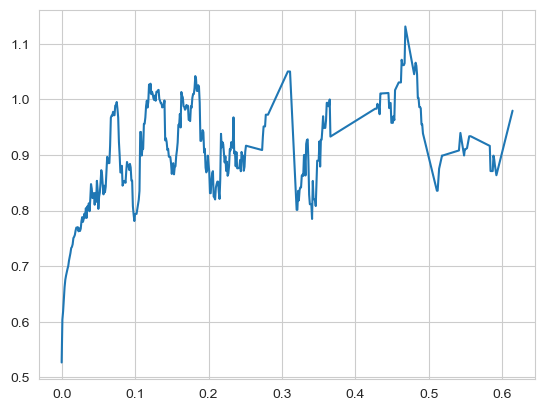

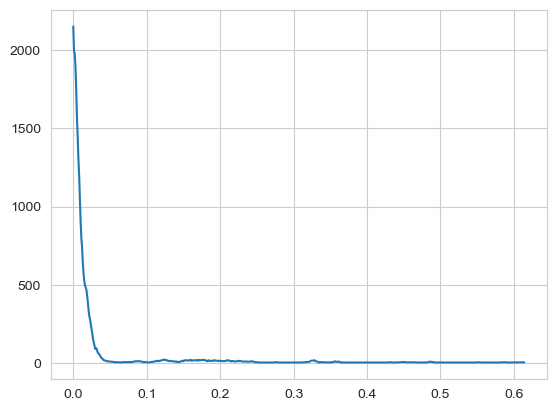

In [118]:
structure = []
function = []
lenss=[]
for i in np.arange(0, 1, 0.001):
    df_op = df_pw_o[(df_pw_o['structure'] >= i) & (df_pw_o['structure'] < i + 0.01)]
    if len(df_op) < 5:
        continue
    structure.append(i)
    function.append(df_op['function'].mean())
    lenss.append(len(df_op))
plt.plot(structure, function)
plt.show()
plt.plot(structure,lenss)

/Users/lyu/anaconda3/envs/transKnow/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


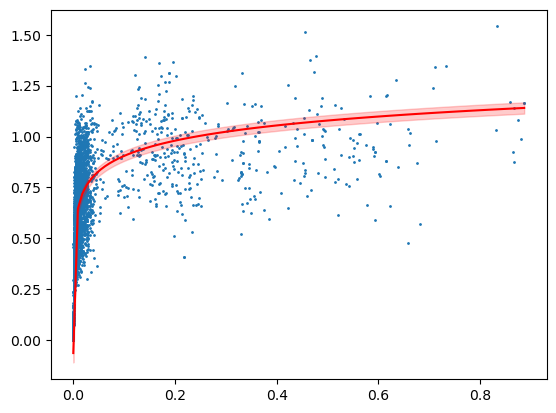

In [365]:
X = df_pw_o['structure']
y = df_pw_o['function']

popt, pcov = curve_fit(log_func, X, y)
X_r = np.linspace(min(X), max(X), num=100)

popt_up = popt + np.sqrt(np.diag(pcov))
popt_low = popt - np.sqrt(np.diag(pcov))

fit_line = log_func(X_r, *popt)
upper_bound = log_func(X_r, *popt_up)
lower_bound = log_func(X_r, *popt_low)

plt.scatter(X, y, label='Data', s=1, marker='o')
plt.plot(X_r, fit_line, 'r', label='Fit')
plt.fill_between(X_r, lower_bound, upper_bound, color='r', alpha=0.2, label='Confidence Interval')
plt.show()

/Users/lyu/anaconda3/envs/transKnow/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6r/x8mllzdj4hbc93v2dg25jt_w0000gn/T/ipykernel_4590/1921670017.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(a * (x + b)) * w


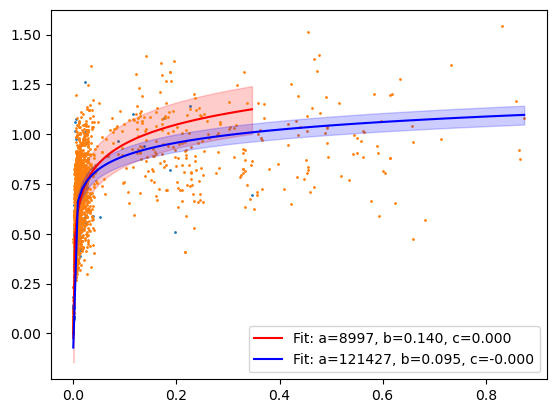

In [381]:
X = df_lc['structure']
y = df_lc['function']

popt, pcov = curve_fit(log_func, X, y)
X_r = np.linspace(min(X), max(X), num=100)

popt_up = popt + np.sqrt(np.diag(pcov))
popt_low = popt - np.sqrt(np.diag(pcov))

fit_line = log_func(X_r, *popt)
upper_bound = log_func(X_r, *popt_up)
lower_bound = log_func(X_r, *popt_low)

plt.scatter(X, y, s=1, marker='o')
plt.plot(X_r, fit_line, 'r', label='Fit: a=%2.0f, b=%.3f, c=%.3f' % tuple(popt.round(3)))
plt.fill_between(X_r, lower_bound, upper_bound, color='r', alpha=0.2)

X = df_gb['structure']
y = df_gb['function']

popt, pcov = curve_fit(log_func, X, y)
X_r = np.linspace(min(X), max(X), num=100)

popt_up = popt + np.sqrt(np.diag(pcov))
popt_low = popt - np.sqrt(np.diag(pcov))

fit_line = log_func(X_r, *popt)
upper_bound = log_func(X_r, *popt_up)
lower_bound = log_func(X_r, *popt_low)

plt.scatter(X, y, s=1, marker='o')
plt.plot(X_r, fit_line, 'b', label='Fit: a=%2.0f, b=%.3f, c=%.3f' % tuple(popt))
plt.fill_between(X_r, lower_bound, upper_bound, color='b', alpha=0.2)

plt.legend()
plt.show()

/Users/lyu/anaconda3/envs/transKnow/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6r/x8mllzdj4hbc93v2dg25jt_w0000gn/T/ipykernel_4590/1921670017.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(a * (x + b)) * w


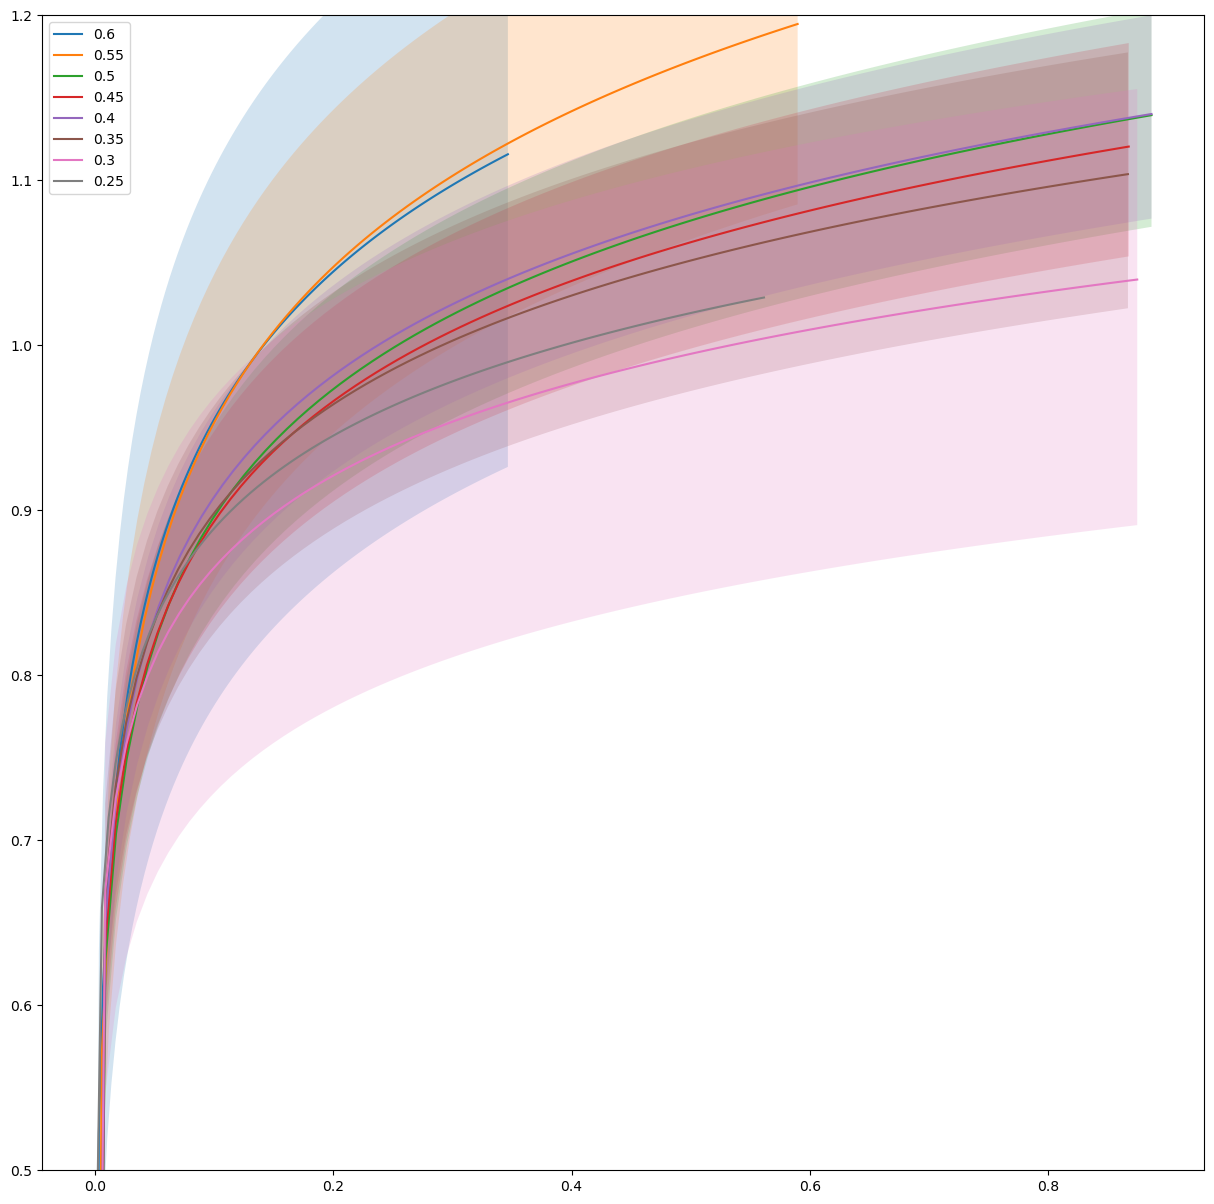

In [422]:
para_a = []
para_w = []
para_b = []

thre = np.arange(0, 1.1, 0.05)

t_list = []
num = []
plt.figure(figsize=(15, 15))
plt.ylim((0.5, 1.2))
for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw[(df_pw['context'] >= thre[i]) & (df_pw['context'] < thre[i + 1])]
    y = df_op['function']
    X = df_op['structure']

    if len(y) < 50:
        continue

    popt, pcov = curve_fit(log_func, X, y)
    X_r = np.linspace(min(X), max(X), num=100)

    X_r = np.linspace(min(X), max(X), num=100)

    popt_up = popt + np.sqrt(np.diag(pcov))
    popt_low = popt - np.sqrt(np.diag(pcov))

    fit_line = log_func(X_r, *popt)
    upper_bound = log_func(X_r, *popt_up)
    lower_bound = log_func(X_r, *popt_low)

    plt.plot(X_r, fit_line, label=str((1 - y_p).round(3)))
    plt.fill_between(X_r, lower_bound, upper_bound, alpha=0.2)

    a, w, b = popt
    if a > 0:
        t_list.append(1 - y_p)
        para_a.append(a)
        para_w.append(w)
        para_b.append(b)
plt.legend()
plt.show()

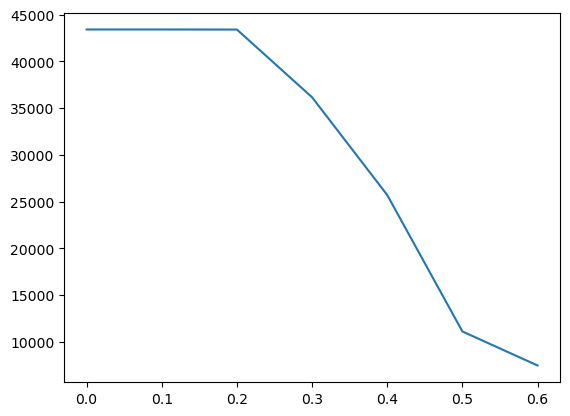

In [421]:
plt.plot(t_list, para_a)

In [ ]:
X = df_pw_o['structure']
y = df_pw_o['function']

popt, pcov = curve_fit(log_func, X, y)
fit_line = log_func(X, *popt)
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

plt.scatter(X, y, label='Data')
plt.plot(X, fit_line, 'r--', label='Fit')
plt.fill_between(X, lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')

plt.legend()
plt.show()

In [289]:
df_pw_o['structure'].quantile(0.7)

0.015698854508656226

In [290]:
df_pw = df_pw_o[df_pw_o['structure'] < 0.015]
cl = df_pw['context'].quantile(0.05)
fr = df_pw['context'].quantile(0.50)

df_lc = df_pw[df_pw['context'] <= cl]
df_gb = df_pw[df_pw['context'] >= fr]

print(cl, fr)
print(len(df_lc), len(df_gb))
print(df_lc.structure.mean(), df_gb.structure.mean())
print(df_lc.function.mean(), df_gb.function.mean())

0.45151471917960345 0.6077717197679974
138 1373
0.00374221868367577 0.007330891586291716
0.3921971065884594 0.6196108256992717


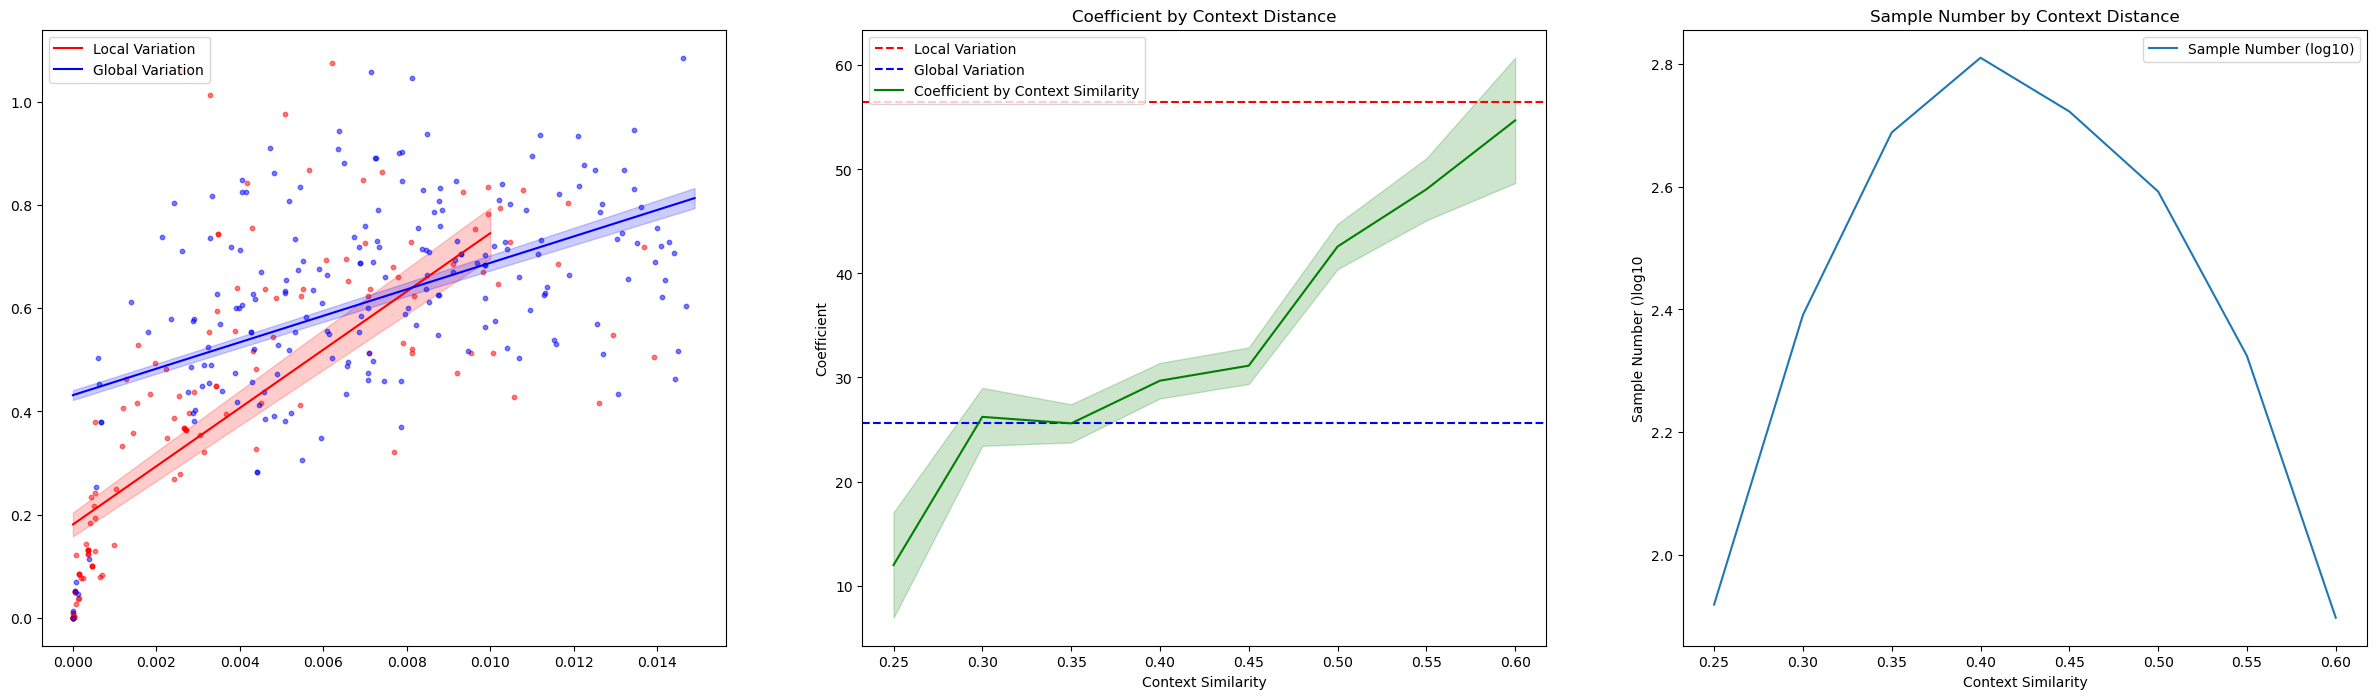

In [291]:
r_squared = []
const = []
para_0 = []
std_err = []
thre = np.arange(0, 1.1, 0.05)

t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw[(df_pw['context'] >= thre[i]) & (df_pw['context'] < thre[i + 1])]
    y = df_op['function']
    X = df_op['structure']

    if len(y) < 50:
        continue

    rsq, c, p0, se = get_OLS_param(X, y)
    t_list.append(1 - y_p)
    num.append(len(y))
    r_squared.append(rsq)
    const.append(c)
    para_0.append(p0)
    std_err.append(se)

r_lc, c_lc, p_lc, _ = get_OLS_param(df_lc['structure'], df_lc['function'])
r_gb, c_gb, p_gb, _ = get_OLS_param(df_gb['structure'], df_gb['function'])

fig = plt.figure(figsize=(30, 8))

ax = fig.add_subplot(1, 3, 1)

X, y = df_lc['structure'], df_lc['function']

popt, pcov = curve_fit(func, X, y)

X_r = np.arange(X.min(), X.max(), 0.01)
fit_line = func(X_r, *popt)
sigma = np.sqrt(np.diag(pcov)[0] * X_r ** 2 + np.diag(pcov)[1])
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

ax.scatter(X, y, c='r', marker='o', s=10, alpha=0.5)
ax.plot(X_r, fit_line, 'r', label='Local Variation')
ax.fill_between(X_r, lower_bound, upper_bound, color='red', alpha=0.2)

X, y = df_gb['structure'], df_gb['function']

popt, pcov = curve_fit(func, X, y)
X_r = np.arange(X.min(), X.max(), 0.0001)
fit_line = func(X_r, *popt)
sigma = np.sqrt(np.diag(pcov)[0] * X_r ** 2 + np.diag(pcov)[1])
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

X_s, y_s = df_gb.sample(200, random_state=42)['structure'], \
    df_gb.sample(200, random_state=42)[
        'function']
ax.scatter(X_s, y_s, c='b', marker='o', s=10, alpha=0.5)
ax.plot(X_r, fit_line, 'b', label='Global Variation')
ax.fill_between(X_r, lower_bound, upper_bound, color='blue', alpha=0.2)

ax.legend(loc='upper left')

para_0 = np.array(para_0)
std_err = np.array(std_err)

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("Coefficient by Context Distance")
ax2.set_ylabel("Coefficient")
#ax2.set_ylim((0, 1))
ax2.set_xlabel("Context Similarity")
ax2.axhline(y=p_lc, color='red', linestyle='--', label='Local Variation')
ax2.axhline(y=p_gb, color='blue', linestyle='--', label='Global Variation')
ax2.plot(t_list, para_0, label='Coefficient by Context Similarity', color='green')
ax2.fill_between(t_list, para_0 + std_err, para_0 - std_err, color='green', alpha=0.2)
ax2.legend(loc='upper left')

ax4 = plt.subplot(1, 3, 3)
ax4.set_title("Sample Number by Context Distance")
ax4.set_ylabel("Sample Number ()log10")
ax4.set_xlabel("Context Similarity")
ax4.plot(t_list, np.log10(np.array(num)), label='Sample Number (log10)')
ax4.legend()
plt.show()

In [262]:
df_pw = df_pw_o[df_pw_o['structure'] > 0.015]
cl = df_pw['context'].quantile(0.05)
fr = df_pw['context'].quantile(0.50)

df_lc = df_pw[df_pw['context'] <= cl]
df_gb = df_pw[df_pw['context'] >= fr]

print(cl, fr)
print(len(df_lc), len(df_gb))
print(df_lc.structure.mean(), df_gb.structure.mean())
print(df_lc.function.mean(), df_gb.function.mean())

0.4901982156464106 0.637840207605222
63 627
0.06299398699834326 0.1199551098010812
0.7548357558544073 0.8314168750498393


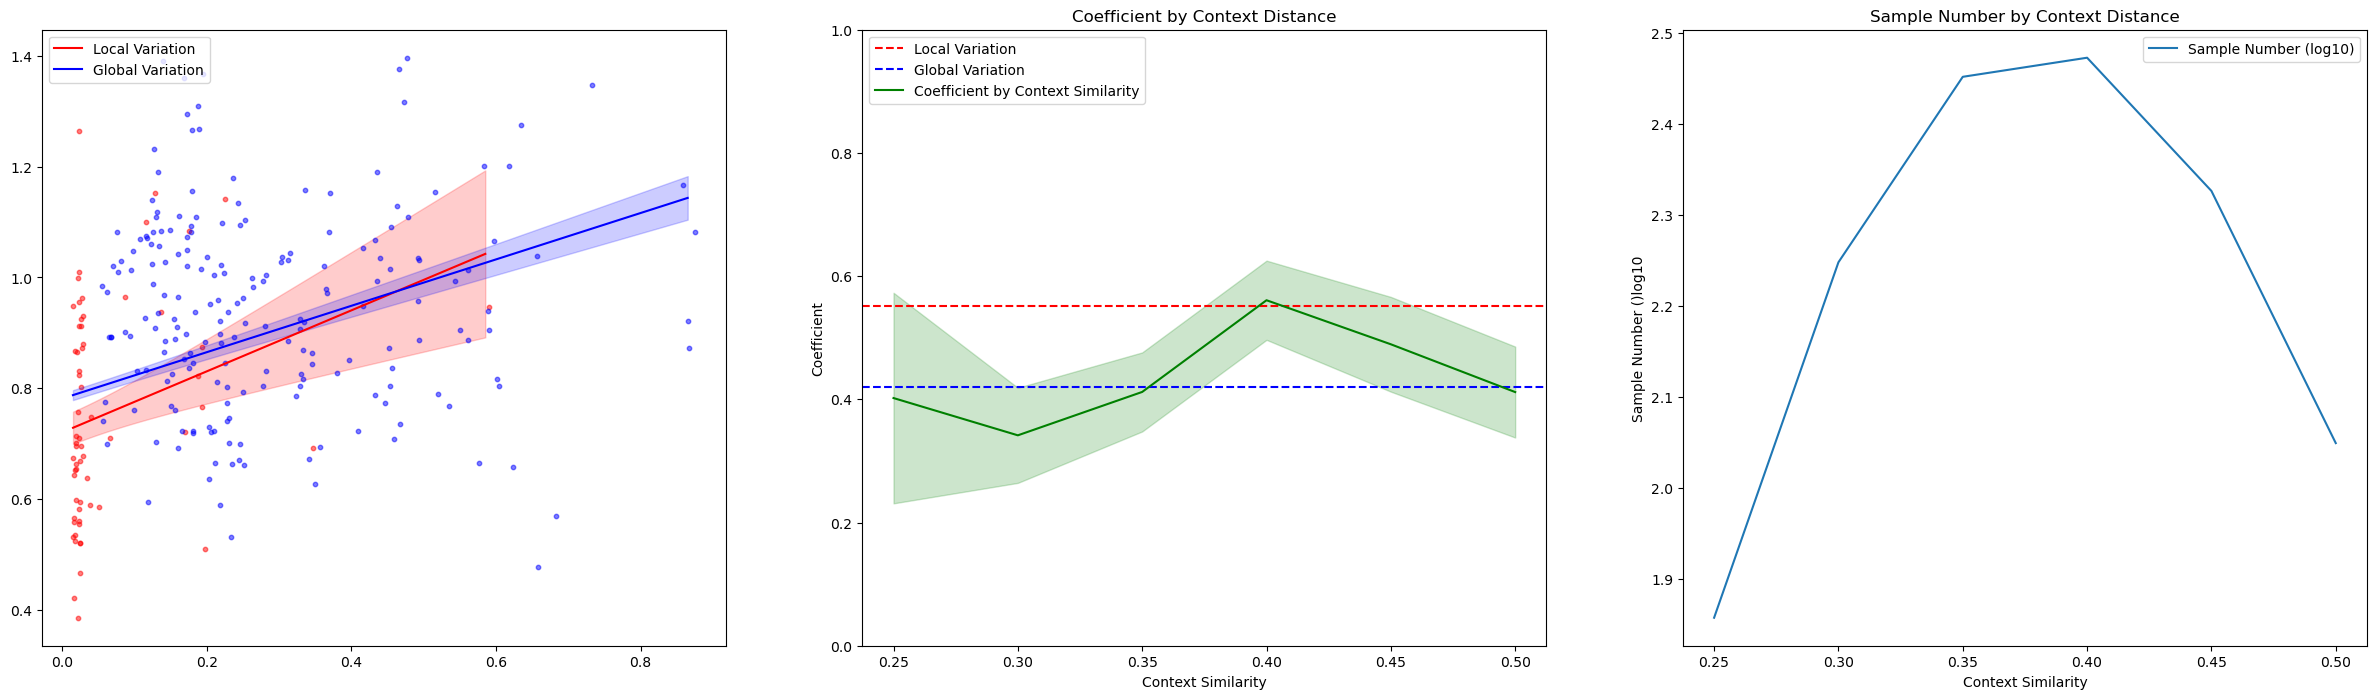

In [264]:
r_squared = []
const = []
para_0 = []
std_err = []
thre = np.arange(0, 1.1, 0.05)

t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw[(df_pw['context'] >= thre[i]) & (df_pw['context'] < thre[i + 1])]
    y = df_op['function']
    X = df_op['structure']

    if len(y) < 50:
        continue

    rsq, c, p0, se = get_OLS_param(X, y)
    t_list.append(1 - y_p)
    num.append(len(y))
    r_squared.append(rsq)
    const.append(c)
    para_0.append(p0)
    std_err.append(se)

r_lc, c_lc, p_lc, _ = get_OLS_param(df_lc['structure'], df_lc['function'])
r_gb, c_gb, p_gb, _ = get_OLS_param(df_gb['structure'], df_gb['function'])

fig = plt.figure(figsize=(30, 8))

ax = fig.add_subplot(1, 3, 1)

X, y = df_lc['structure'], df_lc['function']

popt, pcov = curve_fit(func, X, y)

X_r = np.arange(X.min(), X.max(), 0.01)
fit_line = func(X_r, *popt)
sigma = np.sqrt(np.diag(pcov)[0] * X_r ** 2 + np.diag(pcov)[1])
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

ax.scatter(X, y, c='r', marker='o', s=10, alpha=0.5)
ax.plot(X_r, fit_line, 'r', label='Local Variation')
ax.fill_between(X_r, lower_bound, upper_bound, color='red', alpha=0.2)

X, y = df_gb['structure'], df_gb['function']

popt, pcov = curve_fit(func, X, y)
X_r = np.arange(X.min(), X.max(), 0.01)
fit_line = func(X_r, *popt)
sigma = np.sqrt(np.diag(pcov)[0] * X_r ** 2 + np.diag(pcov)[1])
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

X_s, y_s = df_gb[df_gb['structure'] > 0.05].sample(200, random_state=42)['structure'], \
    df_gb[df_gb['structure'] > 0.05].sample(200, random_state=42)[
        'function']
ax.scatter(X_s, y_s, c='b', marker='o', s=10, alpha=0.5)
ax.plot(X_r, fit_line, 'b', label='Global Variation')
ax.fill_between(X_r, lower_bound, upper_bound, color='blue', alpha=0.2)

ax.legend(loc='upper left')

para_0 = np.array(para_0)
std_err = np.array(std_err)

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("Coefficient by Context Distance")
ax2.set_ylabel("Coefficient")
ax2.set_ylim((0, 1))
ax2.set_xlabel("Context Similarity")
ax2.axhline(y=p_lc, color='red', linestyle='--', label='Local Variation')
ax2.axhline(y=p_gb, color='blue', linestyle='--', label='Global Variation')
ax2.plot(t_list, para_0, label='Coefficient by Context Similarity', color='green')
ax2.fill_between(t_list, para_0 + std_err, para_0 - std_err, color='green', alpha=0.2)
ax2.legend(loc='upper left')

ax4 = plt.subplot(1, 3, 3)
ax4.set_title("Sample Number by Context Distance")
ax4.set_ylabel("Sample Number ()log10")
ax4.set_xlabel("Context Similarity")
ax4.plot(t_list, np.log10(np.array(num)), label='Sample Number (log10)')
ax4.legend()
plt.show()

In [447]:
df_pw_f = pd.read_csv("./df_pw_f.csv")
df_pw_f

,A,B,structure,function,context,cluster,year
0,1168927,945050,0.000882,0.079542,0.167322,False,1
1,945050,989390,0.072934,0.833132,0.401284,False,0
2,989390,1033567,0.048061,0.688747,0.392735,False,1
3,1033567,575199,0.025205,0.786716,0.366708,False,3
4,575199,6251483,0.013674,0.419533,0.201010,False,0
...,...,...,...,...,...,...,...
1974,3539325,3365839,0.062117,0.200284,0.267134,False,1
1975,3931516,3723662,0.460670,1.033789,0.181869,False,1
1976,3723662,3421530,0.086668,0.397618,0.070395,False,2
1977,3894677,4020881,0.041368,0.320324,0.119904,True,0


/Users/lyu/anaconda3/envs/transKnow/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


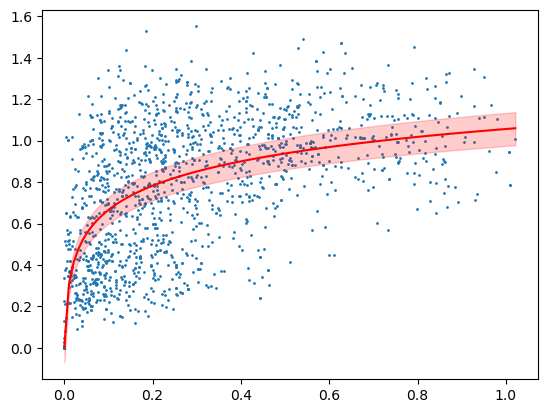

In [449]:
X = df_pw_f['structure']
y = df_pw_f['function']

popt, pcov = curve_fit(log_func, X, y)
X_r = np.linspace(min(X), max(X), num=100)

popt_up = popt + np.sqrt(np.diag(pcov))
popt_low = popt - np.sqrt(np.diag(pcov))

fit_line = log_func(X_r, *popt)
upper_bound = log_func(X_r, *popt_up)
lower_bound = log_func(X_r, *popt_low)

plt.scatter(X, y, label='Data', s=1, marker='o')
plt.plot(X_r, fit_line, 'r', label='Fit')
plt.fill_between(X_r, lower_bound, upper_bound, color='r', alpha=0.2, label='Confidence Interval')
plt.show()

In [463]:
cl = df_pw_f['context'].quantile(0.05)
fr = df_pw_f['context'].quantile(0.50)

df_f_lc = df_pw_f[df_pw_f['context'] <= cl]
df_f_gb = df_pw_f[df_pw_f['context'] >= fr]

print(cl, fr)
print(len(df_f_lc), len(df_f_gb))
print(df_f_lc.function.mean(), df_f_gb.function.mean())

0.10364879027878471 0.2996030432031127
99 990
0.17475733424614867 0.8261111002084448


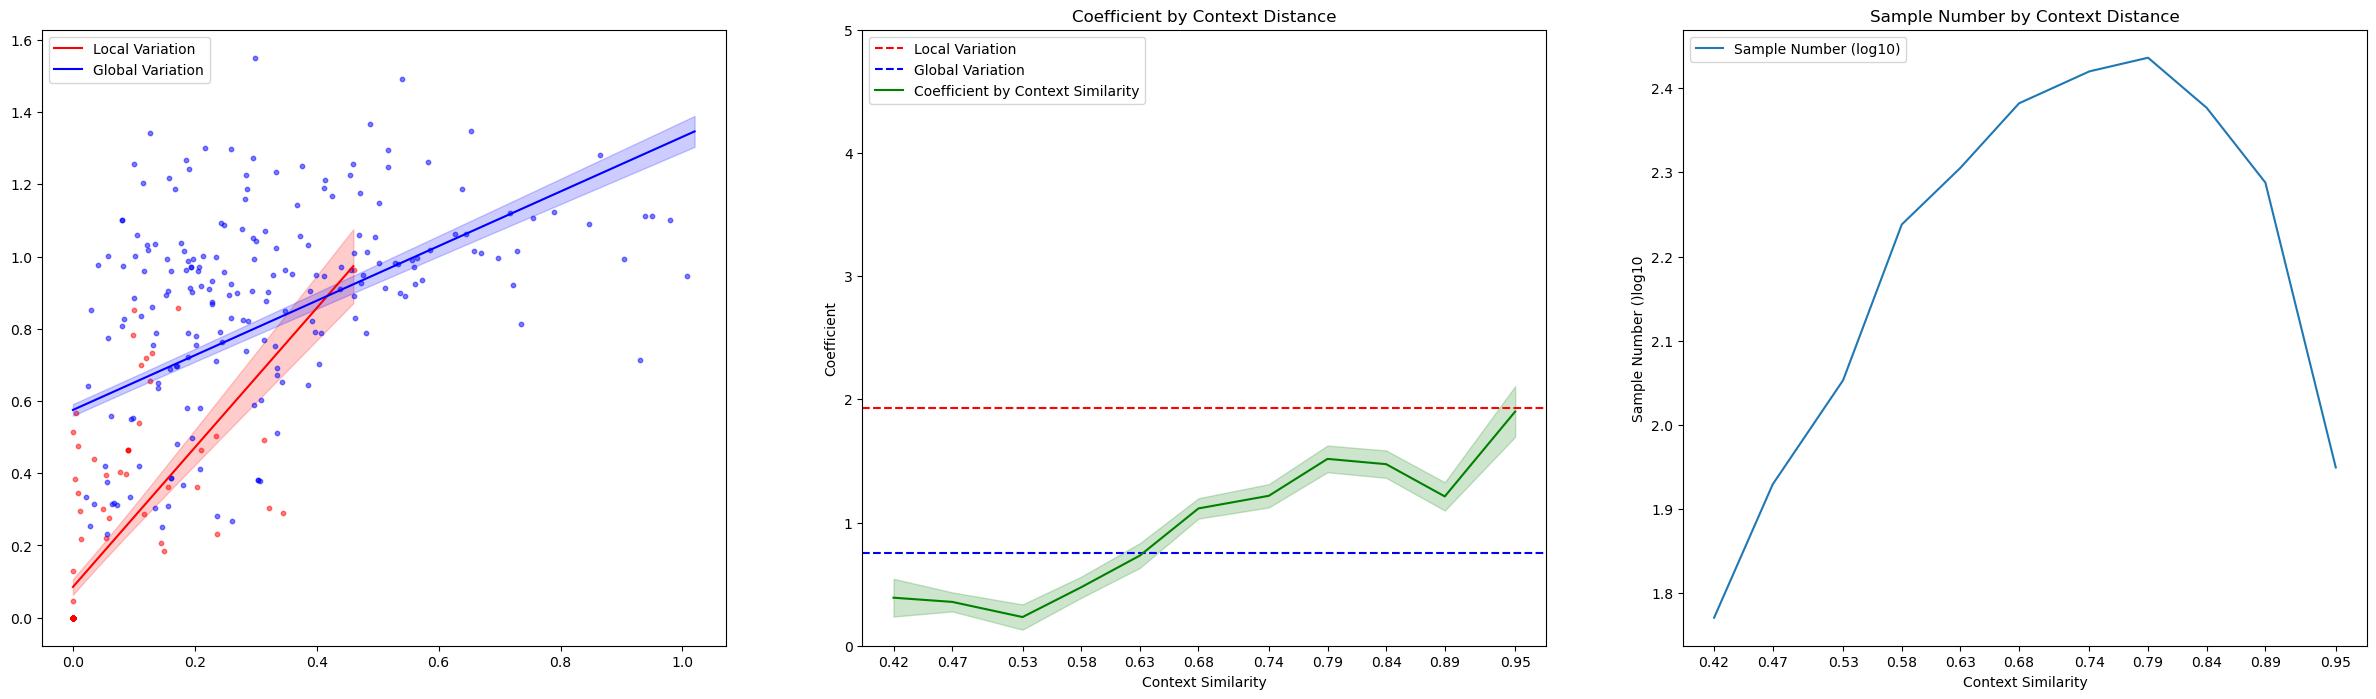

In [468]:
r_squared = []
const = []
para_0 = []
std_err = []
thre = np.linspace(0.0, 1, num=20)
t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw_f[(df_pw_f['context'] >= thre[i]) & (df_pw_f['context'] < thre[i + 1])]
    y = df_op['function']
    X = df_op['structure']

    if len(y) < 50:
        continue

    rsq, c, p0, se = get_OLS_param(X, y)
    t_list.append((1 - y_p).round(decimals=2))
    num.append(len(y))
    r_squared.append(rsq)
    const.append(c)
    para_0.append(p0)
    std_err.append(se)

r_lc, c_lc, p_lc, _ = get_OLS_param(df_f_lc['structure'], df_f_lc['function'])
r_gb, c_gb, p_gb, _ = get_OLS_param(df_f_gb['structure'], df_f_gb['function'])

fig = plt.figure(figsize=(30, 8))

ax = fig.add_subplot(1, 3, 1)

X, y = df_f_lc['structure'], df_f_lc['function']

popt, pcov = curve_fit(func, X, y)

X_r = np.arange(X.min(), X.max(), 0.01)
fit_line = func(X_r, *popt)
sigma = np.sqrt(np.diag(pcov)[0] * X_r ** 2 + np.diag(pcov)[1])
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

ax.scatter(X, y, c='r', marker='o', s=10, alpha=0.5)
ax.plot(X_r, fit_line, 'r', label='Local Variation')
ax.fill_between(X_r, lower_bound, upper_bound, color='red', alpha=0.2)

X, y = df_f_gb['structure'], df_f_gb['function']

popt, pcov = curve_fit(func, X, y)
X_r = np.arange(X.min(), X.max(), 0.01)
fit_line = func(X_r, *popt)
sigma = np.sqrt(np.diag(pcov)[0] * X_r ** 2 + np.diag(pcov)[1])
upper_bound = fit_line + sigma
lower_bound = fit_line - sigma

X_s, y_s = df_f_gb[df_f_gb['structure'] > 0.01].sample(200, random_state=42)['structure'], \
    df_f_gb[df_f_gb['structure'] > 0.01].sample(200, random_state=42)[
        'function']
ax.scatter(X_s, y_s, c='b', marker='o', s=10, alpha=0.5)
ax.plot(X_r, fit_line, 'b', label='Global Variation')
ax.fill_between(X_r, lower_bound, upper_bound, color='blue', alpha=0.2)

ax.legend(loc='upper left')

para_0 = np.array(para_0)
std_err = np.array(std_err)

ax2 = plt.subplot(1, 3, 2)
ax2.set_title("Coefficient by Context Distance")
ax2.set_ylabel("Coefficient")
ax2.set_ylim((0, 5))
ax2.set_xticks(t_list)
ax2.set_xlabel("Context Similarity")
ax2.axhline(y=p_lc, color='red', linestyle='--', label='Local Variation')
ax2.axhline(y=p_gb, color='blue', linestyle='--', label='Global Variation')
ax2.plot(t_list, para_0, label='Coefficient by Context Similarity', color='green')
ax2.fill_between(t_list, para_0 + std_err, para_0 - std_err, color='green', alpha=0.2)
ax2.legend(loc='upper left')

ax4 = plt.subplot(1, 3, 3)
ax4.set_xticks(t_list)
ax4.set_title("Sample Number by Context Distance")
ax4.set_ylabel("Sample Number ()log10")
ax4.set_xlabel("Context Similarity")
ax4.plot(t_list, np.log10(np.array(num)), label='Sample Number (log10)')
ax4.legend()
plt.show()

/Users/lyu/anaconda3/envs/transKnow/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/6r/x8mllzdj4hbc93v2dg25jt_w0000gn/T/ipykernel_4590/1921670017.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(a * (x + b)) * w


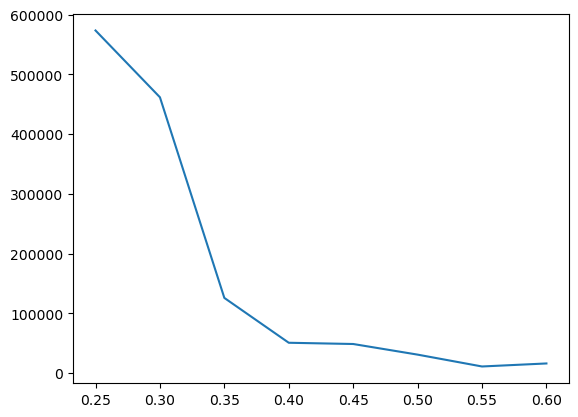

In [457]:
para_a = []
para_w = []
para_b = []

thre = np.arange(0, 1.1, 0.05)

t_list = []
num = []

for i, y_p in enumerate(thre[:-1]):

    df_op = df_pw[(df_pw['context'] >= thre[i]) & (df_pw['context'] < thre[i + 1])]
    y = df_op['function']
    X = df_op['structure']

    if len(y) < 50:
        continue

    popt, pcov = curve_fit(log_func, X, y)
    X_r = np.linspace(min(X), max(X), num=100)

    X_r = np.linspace(min(X), max(X), num=100)

    popt_up = popt + np.sqrt(np.diag(pcov))
    popt_low = popt - np.sqrt(np.diag(pcov))

    fit_line = log_func(X_r, *popt)
    upper_bound = log_func(X_r, *popt_up)
    lower_bound = log_func(X_r, *popt_low)

    a, w, b = popt
    if a > 0:
        t_list.append(1 - y_p)
        para_a.append(a)
        para_w.append(w)
        para_b.append(b)

plt.plot(t_list, para_a)

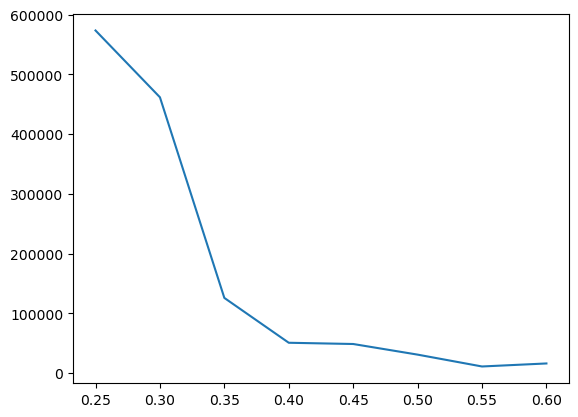

In [456]:
print(log_mediation_scf(df_pw_f).summary())

General Distribution: Structure(Exposure)-Context(Mediator)-Function(y)

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.540594        0.468126        0.620587      0.0
ACME (treated)            0.540594        0.468126        0.620587      0.0
ADE (control)             1.703214        1.572364        1.828004      0.0
ADE (treated)             1.703214        1.572364        1.828004      0.0
Total effect              2.243808        2.125126        2.365022      0.0
Prop. mediated (control)  0.240732        0.208495        0.275802      0.0
Prop. mediated (treated)  0.240732        0.208495        0.275802      0.0
ACME (average)            0.540594        0.468126        0.620587      0.0
ADE (average)             1.703214        1.572364        1.828004      0.0
Prop. mediated (average)  0.240732        0.208495        0.275802      0.0


In [424]:
df_chem = pd.read_csv("./Distance_sample.csv")
df_chem

,dis_y,dis_smile,dis_openai,dis_allan,dis_ntwk
0,2,0.774276,0.214570,0.146348,0.903075
1,2,0.880229,0.674447,0.460471,0.841006
2,2,0.973691,0.727864,0.456514,1.396146
3,13,0.536965,0.362357,0.211945,0.697503
4,0,1.049095,0.304761,0.143197,1.236056
...,...,...,...,...,...
54751,2,0.249591,0.611183,0.464939,1.159873
54752,2,0.787670,0.591967,0.517234,1.060085
54753,0,0.687110,0.728968,0.571559,0.727461
54754,1,0.956661,0.514645,0.423672,1.183305


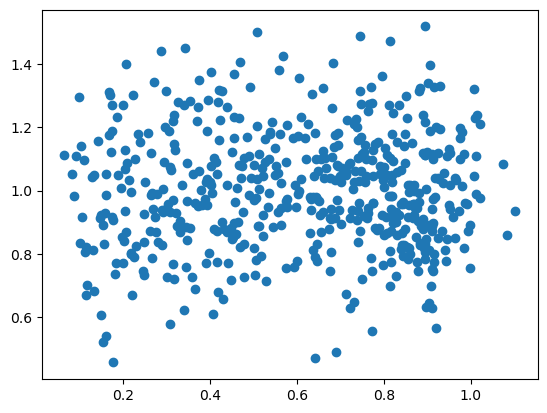

In [434]:
plt.scatter(df_chem[df_chem['dis_openai'] < 0.2]['dis_smile'], df_chem[df_chem['dis_openai'] < 0.2]['dis_ntwk'])

<Axes: >

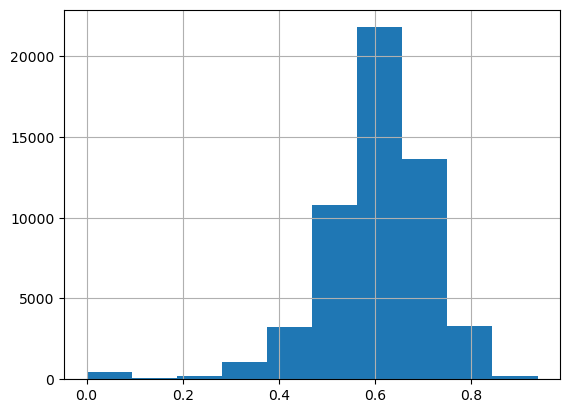

In [432]:
df_chem['dis_openai'].hist()

In [433]:
X, y = df_chem[df_chem['dis_openai'] < 0.2]['dis_smile'], df_chem[df_chem['dis_openai'] < 0.2]['dis_ntwk']

popt, pcov = curve_fit(log_func, X, y)
X_r = np.linspace(min(X), max(X), num=100)

popt_up = popt + np.sqrt(np.diag(pcov))
popt_low = popt - np.sqrt(np.diag(pcov))

fit_line = log_func(X_r, *popt)
upper_bound = log_func(X_r, *popt_up)
lower_bound = log_func(X_r, *popt_low)

plt.scatter(X, y, label='Data', s=1, marker='o')
plt.plot(X_r, fit_line, 'r', label='Fit')
#plt.fill_between(X_r, lower_bound, upper_bound, color='r', alpha=0.2, label='Confidence Interval')
plt.show()

/Users/lyu/anaconda3/envs/transKnow/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

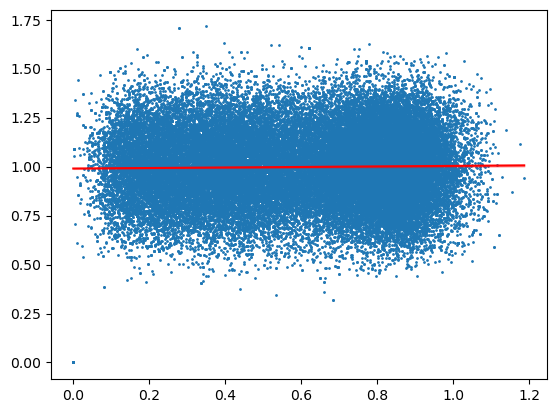

In [431]:
X, y = df_chem['dis_smile'], df_chem['dis_ntwk']

popt, pcov = curve_fit(func, X, y)
X_r = np.linspace(min(X), max(X), num=100)

popt_up = popt + np.sqrt(np.diag(pcov))
popt_low = popt - np.sqrt(np.diag(pcov))

fit_line = func(X_r, *popt)
upper_bound = func(X_r, *popt_up)
lower_bound = func(X_r, *popt_low)

plt.scatter(X, y, label='Data', s=1, marker='o')
plt.plot(X_r, fit_line, 'r', label='Fit')
plt.fill_between(X_r, lower_bound, upper_bound, color='r', alpha=0.2, label='Confidence Interval')
plt.show()